In [1]:
from matplotlib.colors import ListedColormap

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pulp
import seaborn as sns

%load_ext nb_black

<IPython.core.display.Javascript object>

# Data import and analysis

In [2]:
data_path = r"D:\tencent_files\chrome_Download\Research\DEA\Emission_alloc&trade\Data"
data_excel = "Data.xlsx"
sheet_name_ls = [str(i) for i in range(11, 16)]

<IPython.core.display.Javascript object>

In [3]:
def read_data(sheet_name, path=data_path):
    data = pd.read_excel(
        os.path.join(path, data_excel),
        sheet_name=sheet_name,
        header=0,
        index_col=[0, 1, 2],
    )
    return data

<IPython.core.display.Javascript object>

In [4]:
def data_description(data, column):
    col_mean = data.loc[:, column].mean()
    col_max = data.loc[:, column].max()
    col_min = data.loc[:, column].min()
    col_std = data.loc[:, column].std()
    return col_mean, col_max, col_min, col_std

<IPython.core.display.Javascript object>

In [5]:
def meta_data():
    meta_data_dict = {}
    for sheet_name in sheet_name_ls:
        data = read_data(sheet_name)
        year_data_dict = {}
        for column in data.columns:
            column_dict = {}
            year_data_dict[column] = column_dict
            col_mean, col_max, col_min, col_std = data_description(data, column)
            column_dict["mean"] = col_mean
            column_dict["std"] = col_std
            column_dict["max"] = col_max
            column_dict["min"] = col_min
        meta_data_dict[sheet_name] = year_data_dict
    return meta_data_dict

<IPython.core.display.Javascript object>

In [6]:
data_anal = meta_data()

<IPython.core.display.Javascript object>

In [7]:
a = pd.DataFrame.from_dict(
    {(i, j): data_anal[i][j] for i in data_anal.keys() for j in data_anal[i].keys()},
    orient="index",
)  # construct dataframe from multilevel dictionary
a.round(1).to_excel(os.path.join(data_path, "data_description.xlsx"))

<IPython.core.display.Javascript object>

In [8]:
def sum_data(col_name):
    base_case_ls = []
    for sheet_name in sheet_name_ls:
        data = read_data(sheet_name)
        base_case = data.loc[:, col_name].sum()
        base_case_ls.append(base_case)
    return base_case_ls

<IPython.core.display.Javascript object>

In [9]:
base_case_ls = sum_data("Electricity (MWh)")

<IPython.core.display.Javascript object>

In [10]:
base_case_ls

[201795377, 199329717, 201118832, 203765393, 204214422]

<IPython.core.display.Javascript object>

In [11]:
base_case_emission_ls = sum_data("total CO2 (t)")

<IPython.core.display.Javascript object>

In [12]:
base_case_emission_ls

[151995742.01110256,
 148405328.71099156,
 148217248.1876834,
 144061541.98333868,
 145896132.6576116]

<IPython.core.display.Javascript object>

In [13]:
base_case_capacity_ls = sum_data("Capacity (kW)")

<IPython.core.display.Javascript object>

In [14]:
base_case_capacity_ls

[24533600, 24533600, 24533600, 26273600, 25945000]

<IPython.core.display.Javascript object>

# Command and Control

In [15]:
class CAC:
    def __init__(
        self,
        inputs,
        outputs,
        bad_outs,
        returns="CRS",
        disp="weak disposability",
        in_bound=[0, None],
        out_bound=[0, None],
        badout_bound=[0, None],
    ):
        self.inputs = inputs
        self.outputs = outputs
        self.bad_outs = bad_outs
        self.returns = returns
        self.disp = disp

        self.J, self.I = self.inputs.shape  # no of DMUs, inputs
        _, self.R = self.outputs.shape  # no of outputs
        _, self.S = self.bad_outs.shape  # no of bad outputs
        self._i = range(self.I)  # inputs
        self._r = range(self.R)  # outputs
        self._s = range(self.S)  # bad_output
        self._j = range(self.J)  # DMUs

        self._in_bound = in_bound  # input weight restrictions
        self._out_bound = out_bound  # output weight restrictions
        self._badout_bound = badout_bound  # bad output weight restrictions

        # creates dictionary of pulp.LpProblem objects for the DMUs
        self.dmus = self._create_problems()

    def _create_problems(self):
        """
        Iterate over the DMU and create a dictionary of LP problems, one
        for each DMU.
        """

        dmu_dict = {}
        for j0 in self._j:
            dmu_dict[j0] = self._make_problem(j0)
        return dmu_dict

    def _make_problem(self, j0):
        prob = pulp.LpProblem("Output_maximization", pulp.LpMaximize)

        # variables for optimized output
        self.wave_y = pulp.LpVariable.dicts(
            "optimized_y", (self._r), lowBound=self._out_bound[0]
        )

        self.weights = pulp.LpVariable.dicts(
            "weight", (self._j), lowBound=self._in_bound[0]
        )
        # objective function
        prob += pulp.lpSum(self.wave_y)

        for i in self._i:
            prob += (
                pulp.lpSum(
                    [(self.weights[j0] * self.inputs.values[j0][i]) for j0 in self._j]
                )
                <= self.inputs.values[j0][i]
            )

        for r in self._r:
            prob += (
                pulp.lpSum(
                    [(self.weights[j0] * self.outputs.values[j0][r]) for j0 in self._j]
                )
                >= self.wave_y[r]
            )

        if self.disp == "weak disposability":
            for s in self._s:  # weak disposability
                prob += (
                    pulp.lpSum(
                        [
                            (self.weights[j0] * self.bad_outs.values[j0][s])
                            for j0 in self._j
                        ]
                    )
                    == self.bad_outs.values[j0][s]
                )

        elif self.disp == "strong disposability":
            None
        #             for s in self._s:  # strong disposability
        #                 prob += (
        #                     pulp.lpSum(
        #                         [
        #                             (self.weights[j0] * self.bad_outs.values[j0][s])
        #                             for j0 in self._j
        #                         ]
        #                     )
        #                     >= self.bad_outs.values[j0][s]
        #                 )

        return prob

    def solve(self):
        """
        Iterate over the dictionary of DMUs' problems, solve them, and collate
        the results into a pandas dataframe.
        """

        sol_status = {}
        sol_weights = {}
        sol_efficiency = {}

        for ind, problem in list(self.dmus.items()):
            problem.solve()
            sol_status[ind] = pulp.LpStatus[problem.status]
            sol_weights[ind] = {}
            for v in problem.variables():
                sol_weights[ind][v.name] = v.varValue
            sol_efficiency[ind] = pulp.value(problem.objective)
        return sol_status, sol_efficiency, sol_weights

<IPython.core.display.Javascript object>

In [16]:
def data_input_env_reg(data, disp="weak disposability"):
    X = data.loc[:, input_col]
    y = data.loc[:, output_col]
    b = data.loc[:, bad_output_col]
    solve = CAC(X, y, b, disp=disp).solve()
    return solve

<IPython.core.display.Javascript object>

In [17]:
def results_env_reg(data, disp="weak disposability"):
    solve = data_input_env_reg(data, disp=disp)
    status = pd.DataFrame.from_dict(solve[0], orient="index", columns=["status"])
    efficiency = pd.DataFrame.from_dict(
        solve[1], orient="index", columns=["efficiency"]
    )
    weight = pd.DataFrame.from_dict(solve[2], orient="index")
    results = pd.concat([status, efficiency, weight], axis=1)
    return results.round(decimals=4)

<IPython.core.display.Javascript object>

In [18]:
input_col = ["Capacity (kW)", "Energy (kcal)"]
output_col = ["Electricity (MWh)"]
bad_output_col = ["total CO2 (t)"]

<IPython.core.display.Javascript object>

In [19]:
env_reg_ls = []
for i in range(len(sheet_name_ls)):
    data = read_data(sheet_name_ls[i])
    env_reg = results_env_reg(data).loc[:, "optimized_y_0"].sum()
    env_reg_ls.append(env_reg)

<IPython.core.display.Javascript object>

In [20]:
no_env_reg_ls = []
for i in range(len(sheet_name_ls)):
    data = read_data(sheet_name_ls[i])
    no_env_reg = (
        results_env_reg(data, disp="strong disposability").loc[:, "optimized_y_0"].sum()
    )
    no_env_reg_ls.append(no_env_reg)

<IPython.core.display.Javascript object>

In [21]:
env_reg_df = pd.DataFrame(
    [base_case_ls, no_env_reg_ls, env_reg_ls],
    index=["base case", "No env reg", "CAC reg"],
    columns=sheet_name_ls,
)
env_reg_df

,11,12,13,14,15
base case,201795377.0,199329717.0,201118832.0,203765393.0,204214422.0
No env reg,211753600.0,220372520.0,209794900.0,225668880.0,224602107.0
CAC reg,209721134.0,211113000.0,208232280.0,223972860.0,222668017.0


<IPython.core.display.Javascript object>

# Emission Cap and trade

In [39]:
class Emission_trading:
    def __init__(
        self,
        inputs,
        outputs,
        bad_outs,
        bad_outs_cap,
        returns="CRS",
        in_bound=[0, None],
        out_bound=[0, None],
        badout_bound=[0, None],
        cap_percentage=1,
    ):
        self.inputs = inputs
        self.outputs = outputs
        self.bad_outs = bad_outs
        self.bad_outs_cap = bad_outs_cap
        self.returns = returns

        self.J, self.I = self.inputs.shape
        _, self.R = self.outputs.shape
        _, self.S = self.bad_outs.shape
        self._i = range(self.I)  # inputs
        self._r = range(self.R)  # outputs
        self._s = range(self.S)  # bad_output
        self._j = range(self.J)  # DMUs

        self._in_bound = in_bound  # input weight restrictions
        self._out_bound = out_bound  # output weight restrictions
        self._badout_bound = badout_bound  # bad output weight restrictions

        self.problem = self._make_problem()

    def _make_problem(self):
        prob = pulp.LpProblem("Output_maximization", pulp.LpMaximize)

        # variables for optimized output after trade
        self.wave_y = pulp.LpVariable.dicts(
            "optimized_y", (self._j), lowBound=self._out_bound[0]
        )
        self.wave_b = pulp.LpVariable.dicts(
            "optimized_b", (self._j), lowBound=self._badout_bound[0]
        )

        # objective function
        prob += pulp.lpSum([self.wave_y[j0] for j0 in self._j])

        # creating weight variables for each DMU: total weight variables = self._j * self._j
        for j0 in self._j:
            self.weights = pulp.LpVariable.dicts(
                "".join(["weight", str(j0)]), (self._j), lowBound=self._in_bound[0]
            )

            # constraints on inputs of each DMU
            for i in self._i:
                prob += (
                    pulp.lpSum(
                        [
                            (self.weights[j0] * self.inputs.values[j0][i])
                            for j0 in self._j
                        ]
                    )
                    <= self.inputs.values[j0][i]
                )

            # constraints on outputs of each DMU
            for r in self._r:
                prob += (
                    pulp.lpSum(
                        [
                            (self.weights[j0] * self.outputs.values[j0][r])
                            for j0 in self._j
                        ]
                    )
                    >= self.wave_y[j0]
                )

            # constraints on badoutputs of each DMU
            for s in self._s:
                prob += (
                    pulp.lpSum(
                        [
                            (self.weights[j0] * self.bad_outs.values[j0][s])
                            for j0 in self._j
                        ]
                    )
                    == self.wave_b[j0]
                )
                if self.bad_outs_cap is not None:
                    prob += self.wave_b[j0] <= self.bad_outs_cap[j0][s]

        # constraints on aggregate bad output
        prob += pulp.lpSum([self.wave_b[j0] for j0 in self._j]) <= pulp.lpSum(
            [self.bad_outs.values[j0][s] for j0 in self._j]
        )

        return prob

    def solve(self):

        sol_variables = {}

        problem = self.problem
        problem.solve()
        sol_status = pulp.LpStatus[problem.status]
        for v in problem.variables():
            sol_variables[v.name] = v.varValue
        return sol_status, sol_variables

<IPython.core.display.Javascript object>

In [35]:
def data_input(data, data_lag, b_cap=True, cap_percentage=1):
    X = data.loc[:, input_col]
    y = data.loc[:, output_col]
    b = data.loc[:, bad_output_col]
    if b_cap is True:
        b_cap = np.array(data_lag.loc[:, bad_output_col] * cap_percentage)
    else:
        b_cap = None
    solve = Emission_trading(
        X,
        y,
        b,
        bad_outs_cap=b_cap,
    ).solve()
    return solve

<IPython.core.display.Javascript object>

In [36]:
def results(data, data_lag, b_cap=True, cap_percentage=1):
    solve = data_input(data, data_lag, b_cap=b_cap, cap_percentage=cap_percentage)
    optimized_b = {i: j for i, j in solve[1].items() if "optimized_b" in i}
    optimized_b_df = pd.DataFrame.from_dict({"CO2 emissions": optimized_b})
    optimized_y = {i: j for i, j in solve[1].items() if "optimized_y" in i}
    optimized_y_df = pd.DataFrame.from_dict({"electricity_gen": optimized_y})
    return optimized_b_df, optimized_y_df

<IPython.core.display.Javascript object>

In [37]:
def main(b_cap=True):
    results_dict = {}
    for sheet_name in sheet_name_ls:
        if sheet_name != "15":
            data = read_data(sheet_name)
            data_lag = data
            (optimized_b_df, optimized_y_df) = results(data, data_lag, b_cap=b_cap)
            year_results_dict = {}
            year_results_dict.update(dict(optimized_b_df.sum()))
            year_results_dict.update(dict(optimized_y_df.sum()))
            results_dict[sheet_name] = year_results_dict
        else:
            data = read_data(sheet_name)
            data_lag = read_data("15")
            (optimized_b_df, optimized_y_df) = results(data, data_lag, b_cap=b_cap)
            year_results_dict = {}
            year_results_dict.update(dict(optimized_b_df.sum()))
            year_results_dict.update(dict(optimized_y_df.sum()))
            results_dict[sheet_name] = year_results_dict
    results_df = pd.DataFrame.from_dict(results_dict)
    return results_df

<IPython.core.display.Javascript object>

In [40]:
results_df_cap = main()

<IPython.core.display.Javascript object>

In [27]:
results_df_no_cap = main(b_cap=False)

<IPython.core.display.Javascript object>

In [28]:
results_df_cap / results_df_no_cap

,11,12,13,14,15
CO2 emissions,0.991475,0.984726,0.998072,0.992904,0.997411
electricity_gen,0.997744,0.988261,0.998454,0.997807,0.999521


<IPython.core.display.Javascript object>

In [79]:
results_df_cap

,11,12,13,14,15
CO2 emissions,150182112.0,146138633.0,145894504.0,143039310.0,143346973.0
electricity_gen,211275810.0,211948280.0,209470580.0,224973790.0,224494427.0


<IPython.core.display.Javascript object>

In [80]:
results_df_no_cap

,11,12,13,14,15
CO2 emissions,151473382.0,148405365.0,146176324.0,144061524.0,143719073.0
electricity_gen,211753600.0,214465960.0,209794900.0,225468210.0,224602107.0


<IPython.core.display.Javascript object>

# Results analysis

## Aggregated results

In [81]:
elec_gen_df = pd.concat(
    [
        env_reg_df,
        results_df_no_cap.loc[["electricity_gen"]],
        results_df_cap.loc[["electricity_gen"]],
    ]
)
elec_gen_df

,11,12,13,14,15
base case,201795377.0,199329717.0,201118832.0,203765393.0,204214422.0
No env reg,211753600.0,220372520.0,209794900.0,225668880.0,224602107.0
CAC reg,209721134.0,211113000.0,208232280.0,223972860.0,222668017.0
electricity_gen,211753600.0,214465960.0,209794900.0,225468210.0,224602107.0
electricity_gen,211275810.0,211948280.0,209470580.0,224973790.0,224494427.0


<IPython.core.display.Javascript object>

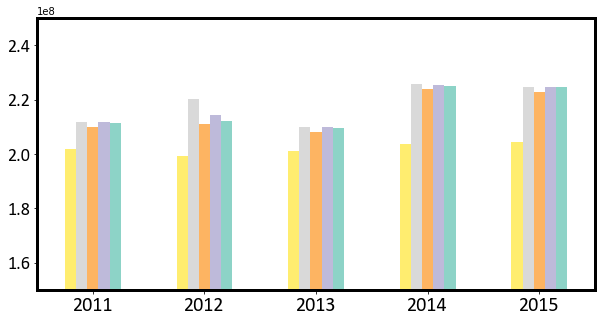

<IPython.core.display.Javascript object>

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.ylim([1.5 * 10 ** 8, 2.5 * 10 ** 8])

elec_gen_df.T.plot(
    kind="bar",
    colormap="Set3_r",
    legend=None,
    ax=ax,
)
loc, labels = plt.xticks()
plt.xticks(
    loc,
    labels=[str(i) for i in range(2011, 2016)],
    fontname="Calibri",
    fontsize=20,
    rotation=0,
)
plt.yticks(
    np.arange(1.6 * 10 ** 8, 2.5 * 10 ** 8, 0.2 * 10 ** 8),
    fontname="Calibri",
    fontsize=18,
)
for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(3)
plt.savefig(
    r"D:\tencent_files\chrome_Download\Research\DEA\Emission_alloc&trade\Figure\Total_output.png",
    transparent=True,
)

In [83]:
((elec_gen_df.iloc[1, :] - elec_gen_df.iloc[0, :]) / elec_gen_df.iloc[1, :])

11    0.047027
12    0.095487
13    0.041355
14    0.097060
15    0.090772
dtype: float64

<IPython.core.display.Javascript object>

In [84]:
((elec_gen_df.iloc[1, :] - elec_gen_df.iloc[0, :]) / elec_gen_df.iloc[1, :]).mean()

0.07434051459687045

<IPython.core.display.Javascript object>

In [85]:
((elec_gen_df.iloc[2, :] - elec_gen_df.iloc[1, :]) / elec_gen_df.iloc[2, :])

11   -0.009691
12   -0.043860
13   -0.007504
14   -0.007572
15   -0.008686
dtype: float64

<IPython.core.display.Javascript object>

In [86]:
((elec_gen_df.iloc[3, :] - elec_gen_df.iloc[2, :]) / elec_gen_df.iloc[3, :])

11    0.009598
12    0.015634
13    0.007448
14    0.006632
15    0.008611
dtype: float64

<IPython.core.display.Javascript object>

In [87]:
((elec_gen_df.iloc[3, :] - elec_gen_df.iloc[2, :]) / elec_gen_df.iloc[3, :]).iloc[
    1:4
].mean()

0.009904839055423352

<IPython.core.display.Javascript object>

In [88]:
((elec_gen_df.iloc[3, :] - elec_gen_df.iloc[4, :]) / elec_gen_df.iloc[3, :])

11    0.002256
12    0.011739
13    0.001546
14    0.002193
15    0.000479
Name: electricity_gen, dtype: float64

<IPython.core.display.Javascript object>

In [89]:
((elec_gen_df.iloc[3, :] - elec_gen_df.iloc[4, :]) / elec_gen_df.iloc[3, :]).iloc[
    -1
] / ((elec_gen_df.iloc[3, :] - elec_gen_df.iloc[2, :]) / elec_gen_df.iloc[3, :]).iloc[
    -1
]

0.05567476177427111

<IPython.core.display.Javascript object>

## Cap and Cost

In [90]:
def cap_trade_2015(b_cap=True, cap_percentage=1):
    results_dict = {}
    data = read_data("15")
    data_lag = read_data("15")
    (optimized_b_df, optimized_y_df) = results(
        data, data_lag, b_cap=b_cap, cap_percentage=cap_percentage
    )
    year_results_dict = {}
    year_results_dict.update(dict(optimized_b_df.sum()))
    year_results_dict.update(dict(optimized_y_df.sum()))
    results_dict[cap_percentage] = year_results_dict
    results_df = pd.DataFrame.from_dict(results_dict)
    return results_df

<IPython.core.display.Javascript object>

In [91]:
cap_percent = np.linspace(0.01, 1, num=100, endpoint=True)
cap_results_ls = []
for percent in cap_percent:
    cap_results = cap_trade_2015(cap_percentage=percent)
    cap_results_ls.append(cap_results)

<IPython.core.display.Javascript object>

In [92]:
cap_results_df = pd.concat(cap_results_ls, axis=1)
cap_results_df.loc[
    :, 0.45:0.55
]  # intercept between current elec-gen and optimized elec_gen is 0.54

,0.45,0.46,0.47,0.48,0.49,0.50,0.51,0.52,0.53,0.54,0.55
CO2 emissions,65653274.0,67112225.0,68571186.0,70030129.0,71489093.0,72948075.0,74407068.0,75865970.0,77324941.0,78783904.0,80242925.0
electricity_gen,198882908.0,199840789.0,200607171.0,201212125.0,201745768.0,202239328.0,202723758.0,203208088.0,203692579.0,204176989.0,204661369.0


<IPython.core.display.Javascript object>

In [93]:
cap_results_df.to_excel(os.path.join(data_path, "abatement.xlsx"))

<IPython.core.display.Javascript object>

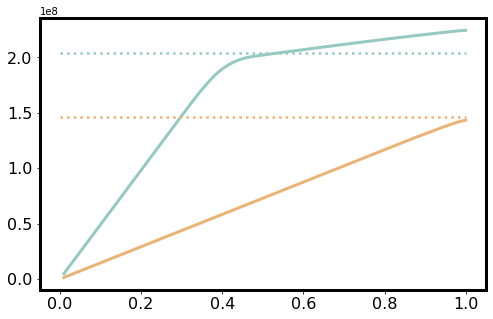

<IPython.core.display.Javascript object>

In [94]:
# plot changes of emission and electricity generation with emission cap
colormap = ListedColormap([[0.92, 0.70, 0.46, 1], [0.59, 0.79, 0.76, 1]])
fig, ax = plt.subplots(figsize=(8, 5))
cap_results_df.T.plot(fontsize=16, colormap=colormap, linewidth=3, legend=None, ax=ax)

# plot base emission and electricity generation
x_coordinate = [0, 1]
y_elec_gen = [base_case_ls[-1], base_case_ls[-1]]
y_emission = [base_case_emission_ls[-1], base_case_emission_ls[-1]]

plt.plot(
    x_coordinate,
    y_elec_gen,
    linestyle="dotted",
    linewidth=2.5,
    color=(0.59, 0.79, 0.76),
)
plt.plot(
    x_coordinate,
    y_emission,
    linestyle="dotted",
    linewidth=2.5,
    color=(0.92, 0.70, 0.46),
)

# graph aesthetic
for side in ax.spines.keys():  # 'top', 'bottom', 'left', 'right'
    ax.spines[side].set_linewidth(3)

plt.savefig(
    r"D:\tencent_files\chrome_Download\Research\DEA\Emission_alloc&trade\Figure\cap_change.png",
    transparent=True,
)

## Distributional effect

In [95]:
def distribution_gain(sheet_name, b_cap=True, cap_percentage=1):
    data = read_data(sheet_name)
    data_lag = data
    reg_y_df = results_env_reg(data, disp="weak disposability").loc[:, "optimized_y_0"]
    ET_b_df, ET_y_df = results(
        data, data_lag, b_cap=b_cap, cap_percentage=cap_percentage
    )
    diff = ET_y_df.reset_index().iloc[:, 1] - reg_y_df
    return diff

<IPython.core.display.Javascript object>

In [96]:
diff_15 = distribution_gain("15", b_cap=False)
diff_15_cap_100 = distribution_gain("15", b_cap=True)
diff_15_cap_75 = distribution_gain("15", b_cap=True, cap_percentage=0.75)
diff_15_cap_50 = distribution_gain("15", b_cap=True, cap_percentage=0.5)
diff_15_cap_25 = distribution_gain("15", b_cap=True, cap_percentage=0.25)

<IPython.core.display.Javascript object>

In [97]:
stipplot_df = pd.concat(
    [diff_15, diff_15_cap_100, diff_15_cap_75, diff_15_cap_50, diff_15_cap_25], axis=1
)

stipplot_df.columns = [
    "no cap",
    "100% cap",
    "75% cap",
    "50% cap",
    "25% cap",
]

<IPython.core.display.Javascript object>

In [98]:
stipplot_df.to_excel(os.path.join(data_path, "distributional_effect.xlsx"))

<IPython.core.display.Javascript object>

In [99]:
import seaborn as sns

<IPython.core.display.Javascript object>

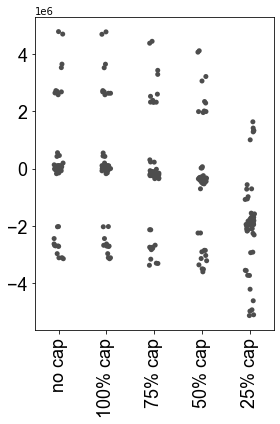

<IPython.core.display.Javascript object>

In [100]:
fig, ax = plt.subplots(figsize=(4, 6))
plt.xticks(fontsize=18, rotation=90, fontname="Arial")
plt.yticks(fontsize=18, fontname="Arial")
sns.stripplot(data=stipplot_df, color=".3", jitter=True)
fig.tight_layout()
plt.savefig(
    r"D:\tencent_files\chrome_Download\Research\DEA\Emission_alloc&trade\Figure\distributional_effect.png",
    transparent=True,
)